# CSGO Match statistics from April 2019 to October 2019 (last 7 months)

In [1]:
import requests
from bs4 import BeautifulSoup
from IPython.core.display import HTML
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
req=requests.get("https://www.hltv.org/stats/matches?startDate=2019-04-01&endDate=2019-10-31&offset=0")
soup=BeautifulSoup(req.text)


In [3]:
soup.title

<title>HLTV.org - The home of competitive Counter-Strike</title>

In [4]:
print(soup.prettify)

<bound method Tag.prettify of <!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8"/>
<meta content="width=device-width, initial-scale=1" id="metaViewport" name="viewport"/>
<meta content="1004164229" property="fb:admins"/>
<meta content="249997999009" property="fb:pages"/>
<meta content="1460388157605817" property="fb:app_id"/>
<meta content="DcypRFLQvgYQL5Acx7feoGWbblSsmKv6HpPI7mM_1uw" name="google-site-verification"/>
<link href="/img/static/favicon/apple-touch-icon.png" rel="apple-touch-icon" sizes="180x180"/>
<link href="/img/static/favicon/favicon-32x32.png" rel="icon" sizes="32x32" type="image/png"/>
<link href="/img/static/favicon/favicon-16x16.png" rel="icon" sizes="16x16" type="image/png"/>
<link href="/img/static/favicon/manifest.json" rel="manifest"/>
<link color="#5bbad5" href="/img/static/favicon/safari-pinned-tab.svg" rel="mask-icon"/>
<meta content="#ffffff" name="theme-color"/>
<link href="https://fonts.googleapis.com/css?family=Open+Sans:400,400i,700,700i|Oswa

In [5]:
table=soup.find_all('table','stats-table')[0]
HTML(str(table))

Date,Team1,Team2,Map,Event
31/10/19,MIBR (16),eUnited (6),inf Inferno,ECS Season 8 North America Week 5
31/10/19,eUnited (11),MIBR (16),trn Train,ECS Season 8 North America Week 5
31/10/19,MIBR (11),eUnited (16),ovp Overpass,ECS Season 8 North America Week 5
31/10/19,Vilay (16),Fantastic (0),inf Inferno,A1 Adria League Season 4
31/10/19,Vilay (16),Fantastic (14),ovp Overpass,A1 Adria League Season 4
31/10/19,mousesports (14),Heroic (16),mrg Mirage,EPICENTER 2019 Europe Closed Qualifier
31/10/19,mousesports (13),Heroic (16),vtg Vertigo,EPICENTER 2019 Europe Closed Qualifier
31/10/19,Virtus.pro (7),fnatic (16),mrg Mirage,ECS Season 8 Europe Week 5
31/10/19,fnatic (16),Virtus.pro (8),ovp Overpass,ECS Season 8 Europe Week 5
31/10/19,Spirit (16),Heretics (10),d2 Dust2,European Champions Cup


In [6]:
# The website is only listing 50 results per page, 
# so we need to scrape them page after page

match_count=int(soup.find_all('span','pagination-data')[0].get_text().split()[-1])
# Need to scrape 76 pages one after the other
num_pages = int(np.ceil(match_count/50.0))
num_pages

186

In [ ]:
base_url='https://www.hltv.org/stats/matches?startDate=2019-04-01&endDate=2019-10-31'
gg=pd.DataFrame()
for i in range(num_pages):
    url = base_url + '&offset='+str(i*50)
    req=requests.get(url)
    soup=BeautifulSoup(req.text)
    table=soup.find_all('table','stats-table')[0]
    rows=[row for row in table.find_all('tr')]
    columns=[col.get_text() for col in rows[0].find_all('th')]
    remnewline=lambda s:s.replace('\n','')
    replacedict={'inf':'','nuke':'','d2':'','ovp':'','trn':'','mrg':'','vtg':'','cch':'','cbl':''}
    def mapclean(s):
        for word,empty in replacedict.items():
            s=s.replace(word,empty)
        return s
    values=[mapclean(remnewline(value.get_text())) for row in rows[1:] for value in row.find_all('td')]
    zippedvalues=list(zip(*[values[i::5] for i in range(len(columns))]))
    df=pd.DataFrame(zippedvalues,columns=columns)
    team1score=re.findall(r'\(.*\)',str(df['Team1']))
    team1score=[int(score.strip('()')) for score in team1score]
    team2score=re.findall(r'\(.*\)',str(df['Team2']))
    team2score=[int(score.strip('()')) for score in team2score]
    df['Team1']=df['Team1'].str.replace('\(.*\)','').str.strip()
    df['Team2']=df['Team2'].str.replace('\(.*\)','').str.strip()
    df['Team1Score']=team1score
    df['Team2Score']=team2score
    gg=pd.concat([gg,df])
    

# Now that we have our dataframe gg. Lets do some exploration:

In [198]:
gg.shape

(7850, 7)

In [199]:
gg.head()

,Date,Team1,Team2,Map,Event,Team1Score,Team2Score
0,25/10/19,Ben's Anime Team,Rap Gang,Mirage,ESEA MDL Season 32 North America,16,14
1,25/10/19,Big Frames,Peeker's Advantage,Overpass,ESEA MDL Season 32 North America,10,16
2,25/10/19,Monstars,Ben's Anime Team,Inferno,ESEA MDL Season 32 North America,8,16
3,25/10/19,Ascent,LiviD,Nuke,ESEA MDL Season 32 North America,16,3
4,24/10/19,ATK,Liquid,Overpass,ECS Season 8 North America Week 4,11,16


# How many matches per event:

In [200]:
gg.groupby('Event')['Team1'].count().sort_values(ascending=False)

Event
ESEA MDL Season 31 North America                                         160
ESEA MDL Season 31 Europe                                                155
UCC Summer Smash                                                         132
ESEA MDL Season 31 Australia                                             131
LOOT.BET Season 3                                                        114
LOOT.BET Season 4                                                        110
Brasil Game Show 2019                                                    100
ESEA MDL Season 32 Australia                                              99
WePlay! Forge of Masters Season 2                                         78
ESEA MDL Season 32 North America                                          78
ESEA MDL Season 32 Europe                                                 72
Americas Minor South America Closed Qualifier - Starladder Major 2019     67
LOOT.BET HotShot Series Season 3                                      

# How many matches played on each map:


In [201]:
gamespermap=gg.groupby('Map')['Team1'].count().sort_values(ascending=False)
gamespermap

Map
Inferno        1536
Mirage         1489
Dust2          1227
Nuke           1094
Overpass       1093
Train          1004
Vertigo         392
Cache            14
Cobblestone       1
Name: Team1, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

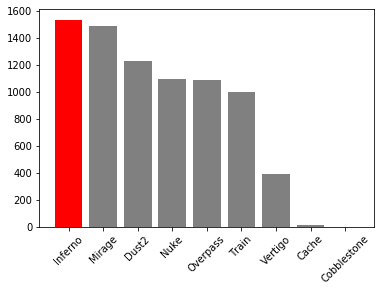

In [202]:
colors=['grey']*8
colors.insert(0,'red')
plt.bar(gamespermap.index,gamespermap.values,color=colors)
plt.xticks(rotation=45)

In [203]:
#dictionary to map each team with their tier

# Natus Vincere 

In [204]:

navi1=gg[gg['Team1']=='Natus Vincere'].copy()
navi1['RoundDiff']=navi1['Team1Score']-navi1['Team2Score']
navi1['Result']=['Win' if i>0 else 'Loss' for i in navi1['RoundDiff']]
mapdiff1=navi1.groupby('Map')['RoundDiff'].sum().sort_index()


In [205]:
navi2=gg[gg['Team2']=='Natus Vincere'].copy()
navi2['RoundDiff']=navi2['Team2Score']-navi2['Team1Score']
navi2['Result']=['Win' if i>0 else 'Loss' for i in navi2['RoundDiff']]
mapdiff2=navi2.groupby('Map')['RoundDiff'].sum().sort_index()
mydict=dict(mapdiff2)

In [206]:
# Navi total round difference per map
for key,value in mydict.items():
    if key in mapdiff1.keys():
        mapdiff1[key]=mapdiff1[key]+value
RoundDiff=mapdiff1.sort_values(ascending=False)

In [207]:
#Navi seem to perform well on inferno and overpass.
# Na'vi total round difference permap
RoundDiff

Map
Inferno     37
Overpass    25
Mirage      11
Train        3
Dust2        3
Nuke         2
Name: RoundDiff, dtype: int64

In [208]:

win2=navi2[navi2.Result=='Win'].groupby('Map')['Result'].count().sort_index()
win1=navi1[navi1.Result=='Win'].groupby('Map')['Result'].count().sort_index()
win1['Train']=0
win2['Nuke']=0
win=win1+win2
win['Vertigo']=0
win

Map
Dust2       5
Inferno     7
Mirage      6
Nuke        4
Overpass    8
Train       2
Vertigo     0
Name: Result, dtype: int64

In [209]:
loss2=navi2[navi2.Result=='Loss'].groupby('Map')['Result'].count().sort_index()
loss1=navi1[navi1.Result=='Loss'].groupby('Map')['Result'].count().sort_index()
loss1['Inferno']=0
loss1['Vertigo']=0
loss=loss1+loss2
loss

Map
Dust2       9
Inferno     1
Mirage      5
Nuke        5
Overpass    5
Train       3
Vertigo     1
Name: Result, dtype: int64

In [211]:
# Navi win rate on each map.
naviwinrate=(win/(win+loss)).sort_values(ascending=False)
naviwinrate

Map
Inferno     0.875000
Overpass    0.615385
Mirage      0.545455
Nuke        0.444444
Train       0.400000
Dust2       0.357143
Vertigo     0.000000
Name: Result, dtype: float64

<BarContainer object of 7 artists>

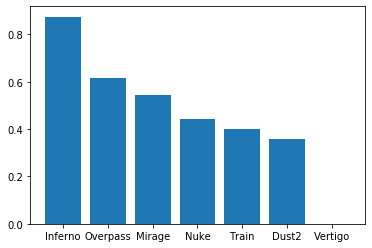

In [214]:
plt.bar(naviwinrate.index,naviwinrate.values)

In [217]:
gg

,Date,Team1,Team2,Map,Event,Team1Score,Team2Score
0,25/10/19,Ben's Anime Team,Rap Gang,Mirage,ESEA MDL Season 32 North America,16,14
1,25/10/19,Big Frames,Peeker's Advantage,Overpass,ESEA MDL Season 32 North America,10,16
2,25/10/19,Monstars,Ben's Anime Team,Inferno,ESEA MDL Season 32 North America,8,16
3,25/10/19,Ascent,LiviD,Nuke,ESEA MDL Season 32 North America,16,3
4,24/10/19,ATK,Liquid,Overpass,ECS Season 8 North America Week 4,11,16
5,24/10/19,ATK,Liquid,Inferno,ECS Season 8 North America Week 4,12,16
6,24/10/19,Liquid,ATK,Dust2,ECS Season 8 North America Week 4,17,19
7,24/10/19,Copenhagen Flames,Movistar Riders,Inferno,United Masters League Season 2 Qualifier 4,16,10
8,24/10/19,Copenhagen Flames,Movistar Riders,Train,United Masters League Season 2 Qualifier 4,9,16
9,24/10/19,Movistar Riders,Copenhagen Flames,Overpass,United Masters League Season 2 Qualifier 4,13,16
